In [3]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.externals import joblib # To save scaler
from keras.models import load_model
import cv2

import importlib
import cnn 
importlib.reload(cnn)

C:\Users\47415\anaconda3\envs\cnn_new\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.


<module 'cnn' from 'C:\\Users\\47415\\Master\\TTK-4900-Master\\src\\cnn.py'>

In [5]:
sinmod_fpath = 'D:/master/data/cmems_data/sinmod/samples_2017.04.27_nonoverlap.nc'

import tools.load_nc

def rotate_vector(u_east, v_north, lons, lon_displacement):
    # Current values in the file are stored as east-north components.
    # We need to read these and rotate into model currents:
    nx, ny = u_east.shape
    # Angle by which we need to rotate currents to get the oriented with the model grid.
    phi = -(np.pi/180)*(lon_displacement-lons)
    u_grid = np.ma.zeros((nx,ny))
    v_grid = np.ma.zeros((nx,ny))
    for i in range(nx):
        for j in range(ny):
            rotMat = np.array([[np.cos(phi[i,j]), -np.sin(phi[i,j])], [np.sin(phi[i,j]),np.cos(phi[i,j])]])
            vel_vec = np.array([[u_east[i,j]],[v_north[i,j]]])
            rotated = rotMat.dot(vel_vec)
            u_grid[i,j] = rotated[0]
            v_grid[i,j] = rotated[1]
    return u_grid, v_grid

xc,yc,lons,lats,sst,ssl,uvel,vvel =  load_nc_sinmod(sinmod_fpath)

x_bnds = [720000, 1560000]
y_bnds = [600000, 1200000]
x_idxs = np.where((xc >= x_bnds[0]) & (xc <= x_bnds[1]))[0]
y_idxs = np.where((yc >= y_bnds[0]) & (yc <= y_bnds[1]))[0]

xc = np.ma.array(xc[x_idxs])
yc = np.ma.array(yc[y_idxs])
lons = np.ma.array(lons[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])
lats = np.ma.array(lats[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])
ssl = np.ma.array(ssl[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])
uvel = np.ma.array(uvel[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])
vvel = np.ma.array(vvel[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])

uvel, vvel = rotate_vector(uvel, vvel, lons, 58)

uvel = np.ma.masked_invalid(uvel)
vvel = np.ma.masked_invalid(vvel)

C:\Users\47415\anaconda3\envs\cnn_new\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Warning: converting a masked element to nan.
  







performing sliding window on satellite data 




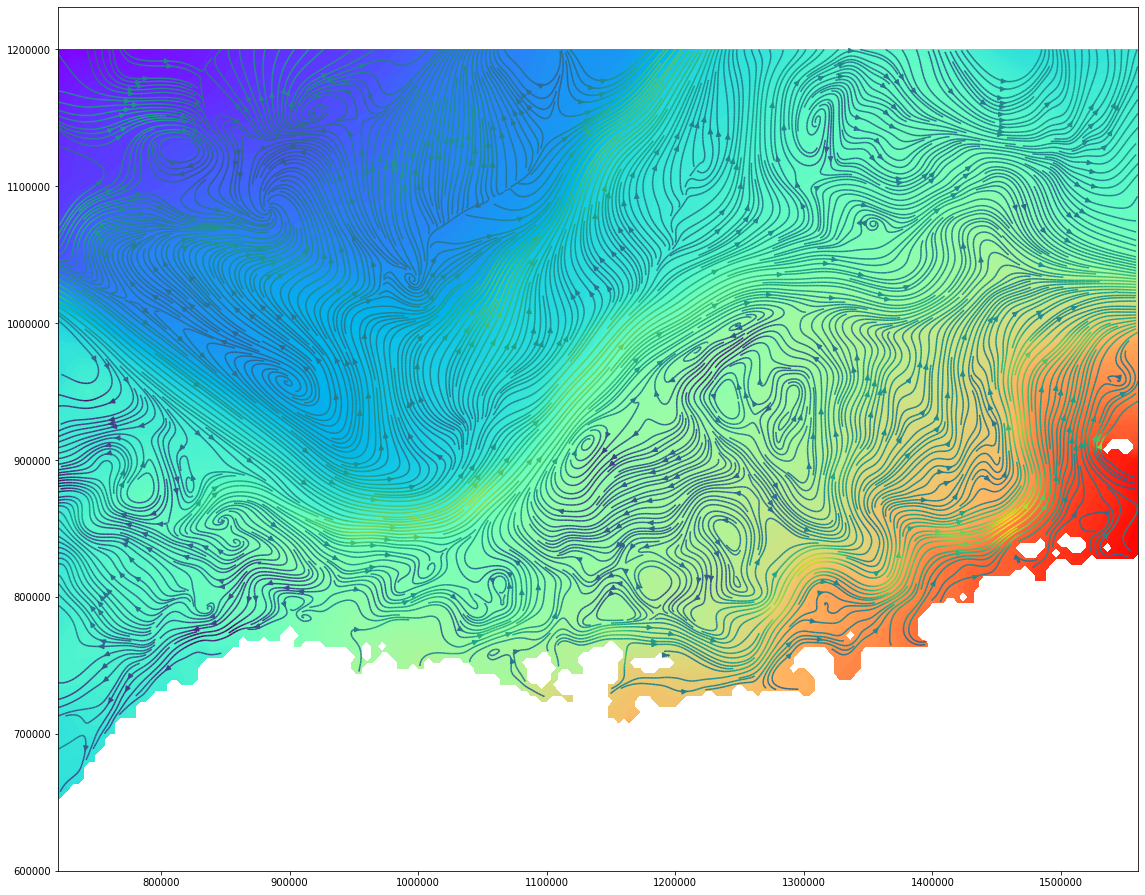

In [9]:
model_fpath = 'D:/master/models/2016/cnn_mult_velocities_9652.h5'
cnn_data = [lons, lats, xc, yc, ssl, uvel, vvel]
win_sizes = [((int(9), int(7)), 2, 2),((int(13), int(10)), 3, 3),((int(16), int(13)), 4, 4)]

# Get the cyclone and anti-cyclone rectangle
cyclones, anticyclones = cnn.test_model(cnn_data, win_sizes, 0.98, model_fpath, create_image=True)

In [12]:
from heapq import merge
from itertools import count
from matplotlib.patches import Rectangle
import pandas as pd

def distance_column(x0, x, y0):
    # xstart, current col/row (width), ystart
    dist_x = (x - x0) ** 2
    yield dist_x, (x, y0) # distance from center, x and y idx
    for dy in count(1):
        dist = dist_x + dy ** 2
        yield dist, (x, y0 + dy)
        yield dist, (x, y0 - dy)

def circle_around(x0, y0, end_x):
    # array with labeled bin clusters, xstart, ystart
    for dist_point in merge(*(distance_column(x0, x, y0) for x in range(end_x))):
        yield dist_point

def find_labeled(labeled, ctr):
    # Start from center index and spiral outwards until we find first of a connected and labeled OW binary cluster
    # Find labeled cluster closest to center of eddy
    nx, ny = labeled.shape
    x0, y0 = ctr
    # Find max width of circle we will investigate
    maxWidth = min(x0, nx-x0, y0, ny-y0)*2
    #labeled_grid = labeled[x0-maxWidth:x0+maxWidth, y0-maxWidth:y0+maxWidth]
    for dist, (x, y) in itertools.islice(circle_around(x0, y0, maxWidth), maxWidth**2):
        if x > maxWidth-1 or y > maxWidth-1:
            return
        if labeled[x,y] > 0:
            return labeled[x,y], (x,y)       

def expand_cluster(OW_eddies_box, box, xy, edge, label):
    """ If we make it through the column/row, we don't have any more OW masks in this dimensions and we return True"""
    
    if xy == 'x':
        n = len(OW_eddies_box[0])
        getidx = lambda idx: (edge, idx)
    else:
        n = len(OW_eddies_box)
        getidx = lambda idx: (idx, edge)
    for i in range(n):
        val = OW_eddies_box[getidx(i)]
        if val == label:
            if xy == 'x': 
                if edge==0: box[0] -= 1; return False
                else:       box[2] += 1; return False
            else:        
                if edge==0: box[1] -= 1; return False
                else:       box[3] += 1; return False              
    return True

def include_full_cluster(labeled_array, box, label):
    """ labeled_array: Labels of binary clusters
        box: mutable list of box indexes passed by reference
        label: What label to include when increasing box"""
    
    #print(f"++Box shape before: {box}")
    for xy, edge in (('x', 0), ('x', -1), ('y', 0), ('y', -1)):
        i, maxit = 0, 50
        done = False
        # While we have more masks in this edge and dimension that are correct label -> continue to increase box size 
        while(not done):
            i += 1
            if i > maxit: return 0; print("Hit iteration marker, while loop stuck")
            # If we are at edge dimensions of full array, just continue
            # We need to check if the current first or last dimension of col or row is larger or smaller than allowed
            box2d = {'x': [box[0], box[2]], 'y':[box[1], box[3]]}
            if box2d[xy][edge] in (0, labeled_array.shape[edge]): 
                #print(f"dimension {xy} at edge {edge} is too large or small")
                break 
            labeled_box = labeled_array[box[0]:box[2], box[1]:box[3]]
            done = expand_cluster(labeled_box, box, xy, edge, label)
            #print(f"are we done?: [{done}], box: {box}")
    #print(f"++Box shape after: {box}")
    return 1

def investigate_cluster(eddy_boxes, OW, OW_labeled, eddytype='cyclone'):
    """Check if the cluster is larger than the box boundaries and increase box size to encompass full cluster"""
    boxes_copy = np.zeros((len(eddy_boxes), 4), dtype=int)
    ctrIdxs = np.empty((len(eddy_boxes)), dtype=object)
    nCells = np.zeros(len(eddy_boxes))
    minOW = np.zeros(len(eddy_boxes))
    for boxId, b in enumerate(eddy_boxes):
        boxes_copy[boxId] = b[:]
        OW_box = OW[b[0]:b[2], b[1]:b[3]]
        ctrIdxs[boxId] = tuple(np.argwhere(OW_box == np.min(OW_box))[0])
        minOW[boxId] = OW_box[ctrIdxs[boxId]]
        # Create array of the labeled OW clusters
        labeled_arr = OW_labeled[b[0]:b[2], b[1]:b[3]]
        # Get the label of the cluster at the minima, if no cluster present, delete from boxes
        label = labeled_arr[ctrIdxs[boxId]]
        print(f"Investigating {eddytype} nr {boxId} | label: {label} | box: {b} | center Idx: {ctrIdxs[boxId]}")
        if label <= 0:
            # TODO: Implement to delete array if needed
            print(f"No cluster in box {boxId}")
            nCells[boxId] = (labeled_arr == label).sum()
            continue
        # Increase the box size to encompass the whole labeled OW cluster
        if not include_full_cluster(OW_labeled, boxes_copy[boxId], label): 
            print("While loop stuck")
        # Count number of cells in cluster with same label
        nCells[boxId] = (labeled_arr == label).sum()
    print("")
    return ctrIdxs, nCells, minOW, boxes_copy

def plot_eddies(fig, ax, eddy, color='r'):
    for i, r in enumerate(eddy):
        rec = Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], edgecolor=color, linewidth=1.5,facecolor='none')
        ax.add_patch(rec)
        ax.annotate(str(i+1), (int(r[0]+(r[2]-r[0])/2-1), int(r[1]+(r[3]-r[1])/2)-1), color='white')
        
def create_image(fig, nx, ny):        
    im = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    im = im.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    imCopy = cv2.cvtColor(im,cv2.COLOR_RGB2BGR)
    imH, imW, _ = imCopy.shape # col, row
    winScaleW, winScaleH = imW*1.0/nx, imH*1.0/ny # Scalar coeff from dataset to cv2 image
    return im, winScaleW, winScaleH

def set_eddy_census(census, ctrIdxs, nCells, boxes, minOW, xc, yc, lon, lat, res=0.083):
    for i, b in enumerate(boxes):
        OW_box = OW[b[0]:b[2], b[1]:b[3]]
        lon_box = lon[b[0]:b[2], b[1]:b[3]]
        lat_box = lat[b[0]:b[2], b[1]:b[3]]
        census[i, 0] = minOW[i]
        census[i, 1] = lon_box[ctrIdxs[i]]
        census[i, 2] = lat_box[ctrIdxs[i]]
        census[i, 3] = nCells[i]
        width = xc[b[0]]-xc[b[2]]
        height = yc[b[1]-b[3]]
        census[i, 4] = width
        census[i, 5] = height
        
    name_list = ['minOW','lon[º]','lat[º]','cells','width[km]','height[km]']   
    df = pd.DataFrame(census, index= np.arange(1,len(boxes)+1), columns=name_list)
    return df

In [26]:
import tools.my_eddies
importlib.reload(tools.my_eddies)
from skimage import measure

# OW value at which to begin the evaluation of R2, default was -1, want to use -8 to be absolutely sure
OW_start = -0.01
OW, vorticity, OW_eddies, cyc_mask, acyc_mask = tools.my_eddies.calc_OW(xc,yc,uvel,vvel,OW_start)

# We label all the connected OW masks
from skimage import measure
OW_labeled = measure.label(OW_eddies)
cyc_labeled = measure.label(cyc_mask)
acyc_labeled = measure.label(acyc_mask)

In [27]:
cyc, _ = cv2.groupRectangles(rectList=cyclones, groupThreshold=2, eps=0.2)
acyc, _ = cv2.groupRectangles(rectList=anticyclones, groupThreshold=2, eps=0.2)
    
nx, ny = uvel.shape
nCyc = len(cyc)
nAcyc = len(acyc)
nEddies = nCyc*nAcyc

# Eddy census to hold information about each eddy
cyclone_census = np.zeros((nCyc, 6))
anticyclone_census = np.zeros((nAcyc, 6))

cyc_ctrIdxs, cyc_nCells, cyc_minOW, cyc_new = investigate_cluster(cyc, OW, cyc_labeled, 'cyclone')
acyc_ctrIdxs, acyc_nCells, acyc_minOW, acyc_new = investigate_cluster(acyc, OW, acyc_labeled, 'anti-cyclone')

Investigating cyclone nr 0 | label: 140 | box: [111  50 122  56] | center Idx: (4, 5)
Investigating cyclone nr 1 | label: 47 | box: [26 60 37 66] | center Idx: (5, 4)
Investigating cyclone nr 2 | label: 20 | box: [11 65 22 71] | center Idx: (7, 3)
Investigating cyclone nr 3 | label: 36 | box: [ 18 128  29 134] | center Idx: (7, 3)
Investigating cyclone nr 4 | label: 168 | box: [142 133 153 139] | center Idx: (6, 3)
Investigating cyclone nr 5 | label: 58 | box: [ 44 136  55 142] | center Idx: (6, 4)

Investigating anti-cyclone nr 0 | label: 0 | box: [125  52 136  58] | center Idx: (2, 3)
No cluster in box 0
Investigating anti-cyclone nr 1 | label: 136 | box: [124  82 135  88] | center Idx: (0, 4)
Investigating anti-cyclone nr 2 | label: 50 | box: [38 85 49 91] | center Idx: (6, 0)
Investigating anti-cyclone nr 3 | label: 51 | box: [ 35 116  46 122] | center Idx: (7, 2)



In [15]:
cyc_census_df = set_eddy_census(cyclone_census, cyc_ctrIdxs, cyc_nCells, cyc_new, cyc_minOW, xc, yc, lons, lats)
acyc_census_df = set_eddy_census(anticyclone_census, acyc_ctrIdxs, acyc_nCells, acyc_new, acyc_minOW, xc, yc, lons, lats)

In [28]:
cyc_census_df

minOW    lon[º]     lat[º]  cells  width[km]  height[km]
1 -1.214266  7.974281  64.442253   14.0   -56000.0   1172000.0
2 -1.213877  3.225082  62.211082   14.0   -64000.0   1164000.0
3 -1.879871  2.348732  61.745659   37.0   -64000.0   1172000.0
4 -0.653924 -1.447838  63.333908   22.0   -64000.0   1176000.0
5 -0.567037  4.097481  67.138275   26.0   -52000.0   1160000.0
6 -0.170268 -1.202030  64.162399   38.0   -80000.0   1176000.0

In [17]:
acyc_census_df

minOW    lon[º]     lat[º]  cells  width[km]  height[km]
1 -0.498211  8.638680  64.778099   65.0   -44000.0   1180000.0
2 -2.039045  6.342995  65.337753   33.0   -52000.0   1176000.0
3 -0.124039  2.576412  62.863476   15.0  -112000.0   1164000.0
4 -0.240890  0.114460  63.636452   33.0   -72000.0   1172000.0

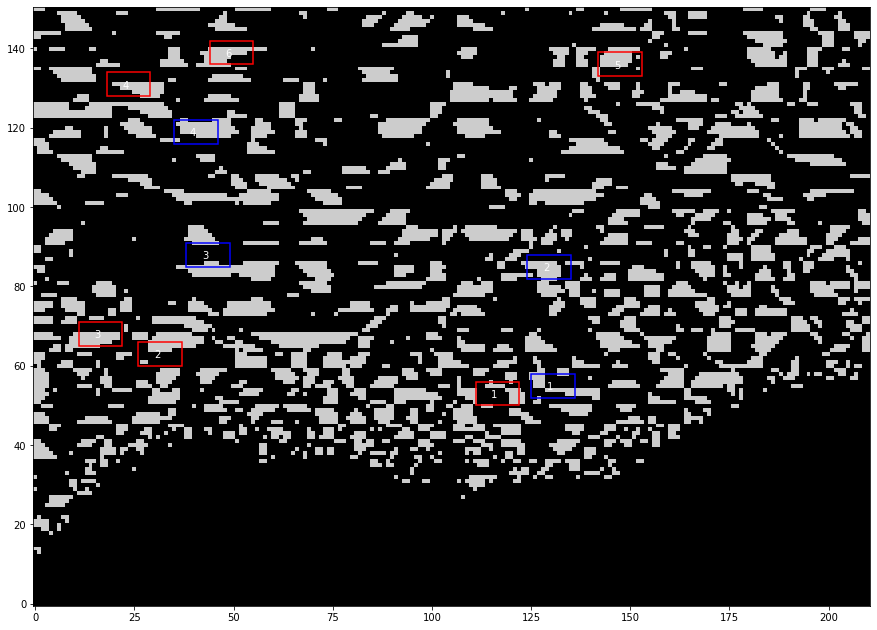

In [29]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
ax.imshow(OW_eddies.T, cmap='nipy_spectral', origin='lower')
plot_eddies(fig, ax, cyc, 'r') 
plot_eddies(fig, ax, acyc, 'b') 

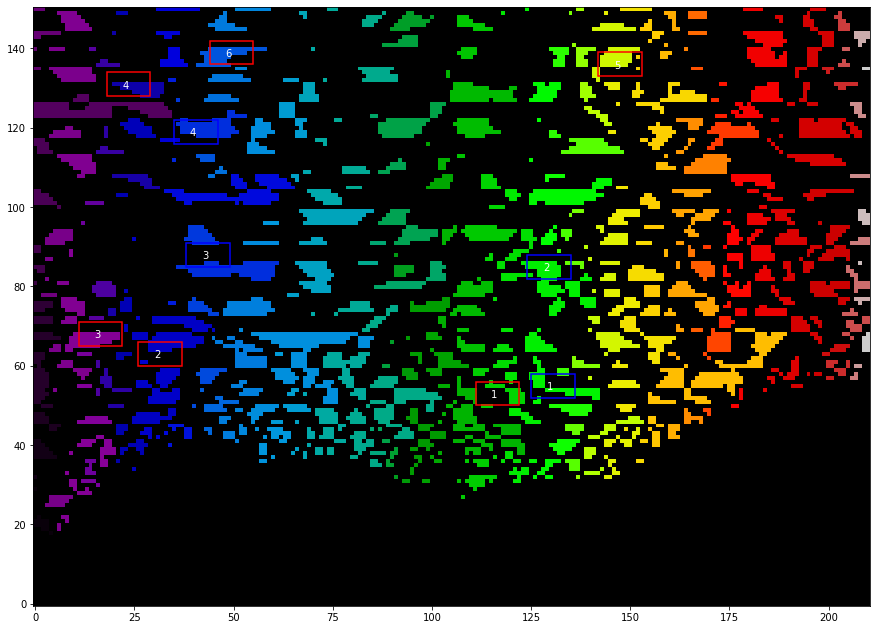

In [19]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
ax.imshow(OW_labeled.T, cmap='nipy_spectral', origin='lower')
plot_eddies(fig, ax, cyc, 'r') 
plot_eddies(fig, ax, acyc, 'b') 

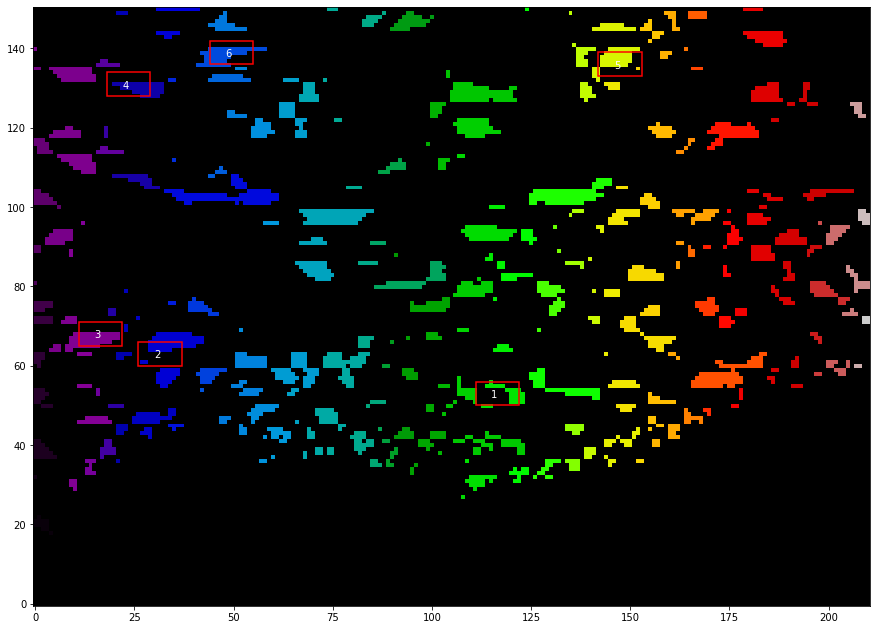

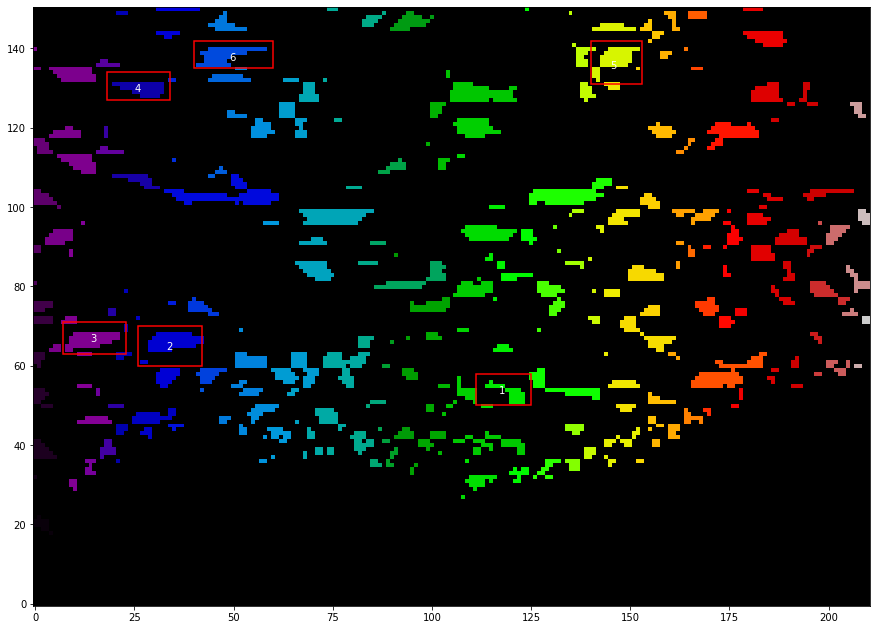

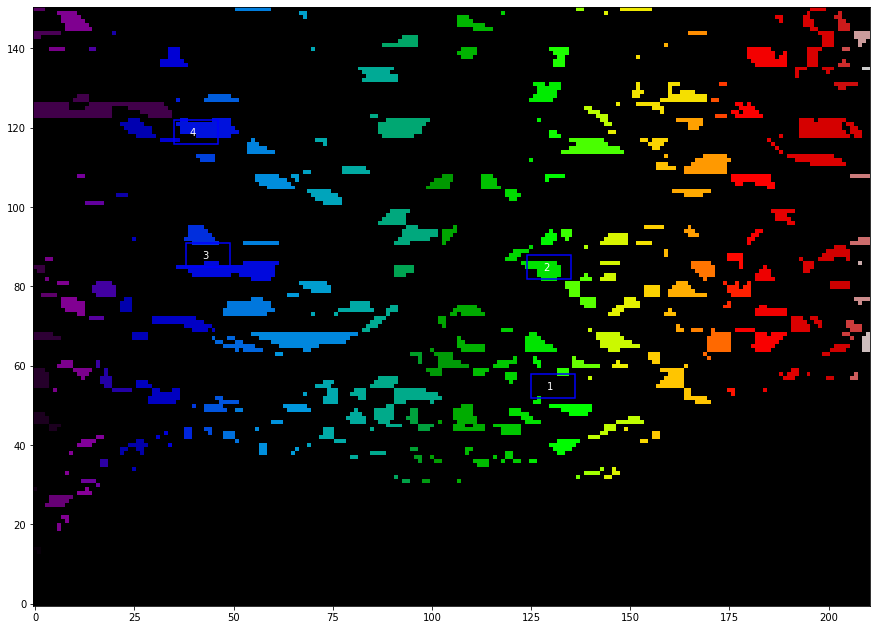

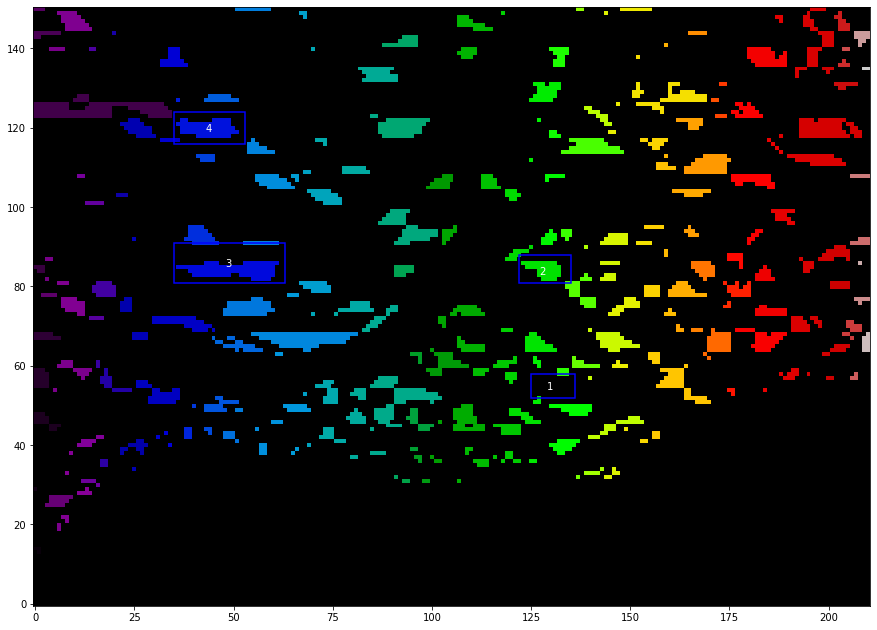

In [20]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
ax.imshow(cyc_labeled.T, cmap='nipy_spectral', origin='lower')
plot_eddies(fig, ax, cyc, 'r')
#plt.savefig('clusters_before.png') 


fig, ax = plt.subplots(1,1,figsize=(15,12))
ax.imshow(cyc_labeled.T, cmap='nipy_spectral', origin='lower')
plot_eddies(fig, ax, cyc_new, 'r') 

fig, ax = plt.subplots(1,1,figsize=(15,12))
ax.imshow(acyc_labeled.T, cmap='nipy_spectral', origin='lower')
plot_eddies(fig, ax, acyc, 'b') 

fig, ax = plt.subplots(1,1,figsize=(15,12))
ax.imshow(acyc_labeled.T, cmap='nipy_spectral', origin='lower')
plot_eddies(fig, ax, acyc_new, 'b')

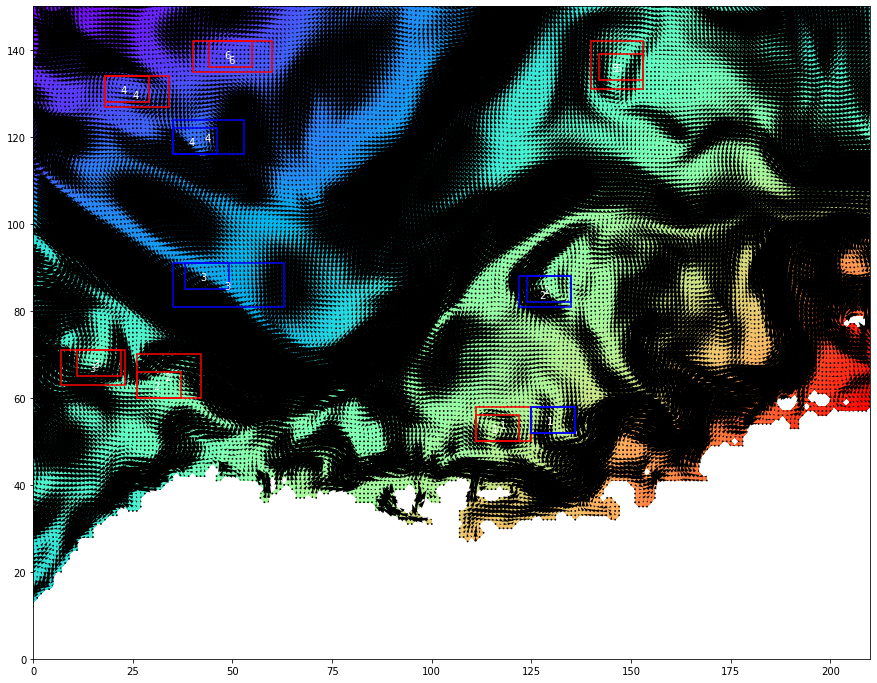

In [21]:
x, y = np.arange(len(xc)),  np.arange(len(yc)) 
n=-1
color_array = np.sqrt(((uvel-n)/2)**2 + ((vvel-n)/2)**2)

fig, ax = plt.subplots(1,1,figsize=(15,12))

ax.contourf(x, y, ssl.T, cmap='rainbow', levels=100)
ax.quiver(x, y, uvel.T, vvel.T, scale=10)
plot_eddies(fig, ax, cyc, 'r') 
plot_eddies(fig, ax, cyc_new, 'r') 
plot_eddies(fig, ax, acyc, 'b') 
plot_eddies(fig, ax, acyc_new, 'b') 

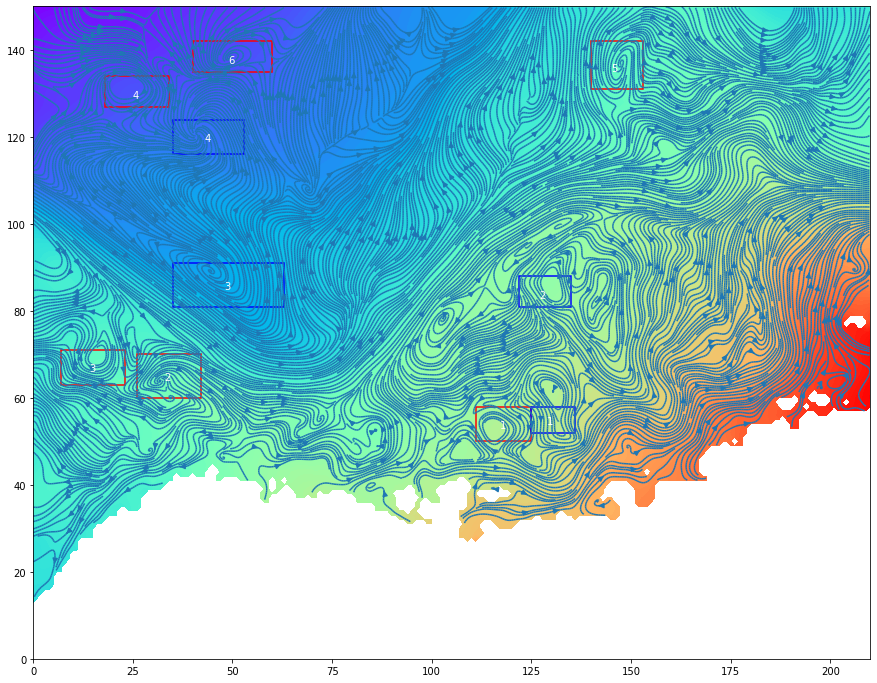

In [22]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
ax.contourf(x, y, ssl.T, cmap='rainbow', levels=150)
ax.streamplot(x, y, uvel.T, vvel.T, density=12)
plot_eddies(fig, ax, cyc_new, 'r') 
plot_eddies(fig, ax, acyc_new, 'b') 